# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import librosa
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import librosa.display
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the Data
unlabelled_data_path = "/content/drive/My Drive/unlabelled_sounds/"

files = librosa.util.find_files(unlabelled_data_path)

In [4]:
# Extract Mel Spectrogram features
features = []
for file in files:
    y, sr = librosa.load(file)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    features.append(np.mean(mel_spectrogram, axis=1))

features_array = np.array(features)


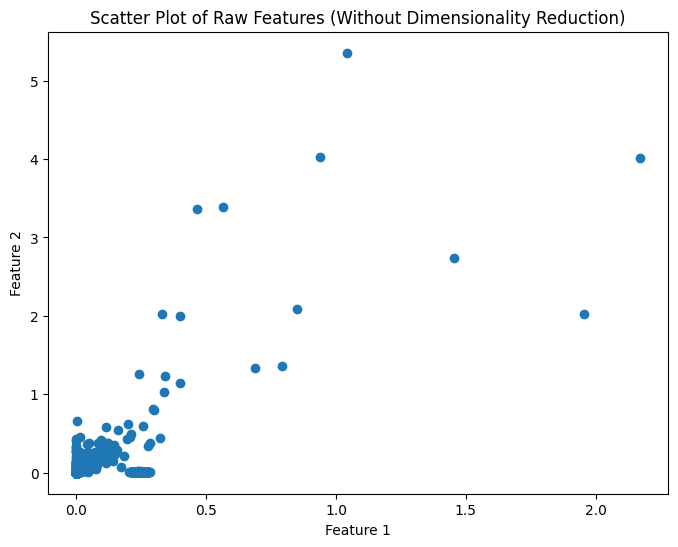

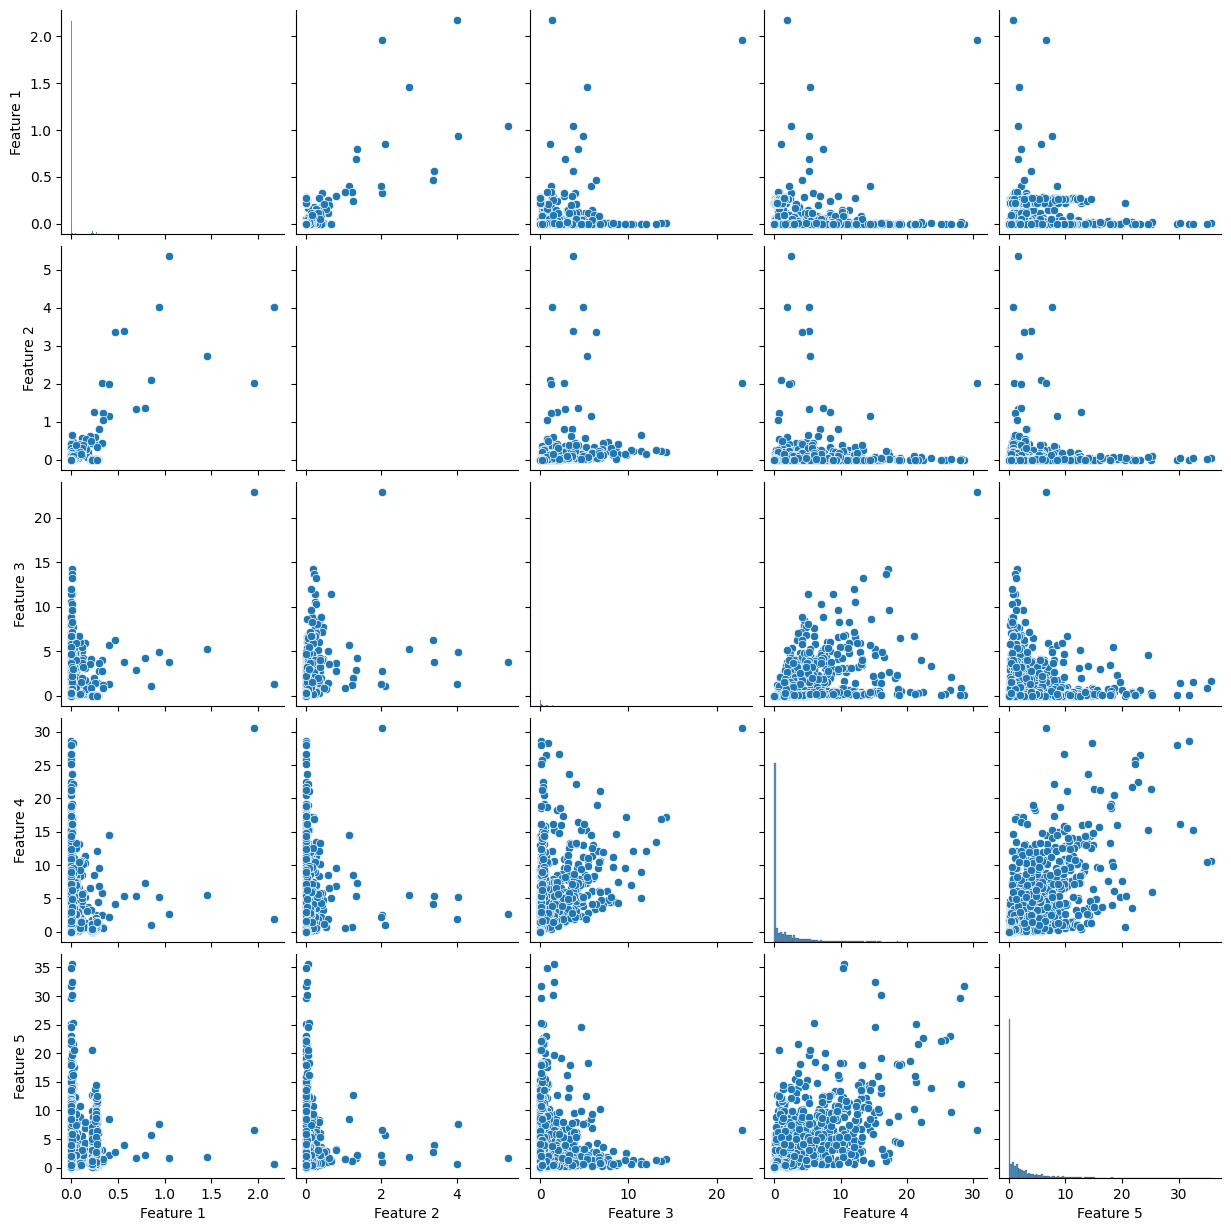

In [9]:
# scatter plot without dimensionality reduction
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Convert to DataFrame for pairplot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f"Feature {i}" for i in range(1, 6)])
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?
Reducing dimensionality was important because high-dimensional data was hard to handle. I discovered that pattern recognition was challenging because of non-linear relationships between features, an extremely imbalanced data distribution, and cluster overlap. The issue was compounded by the Curse of Dimensionality, where data points appeared equidistant, reducing the effectiveness of clustering and making processing costly.

To enhance efficiency and grouping, I utilized PCA to remove redundancy without compromising significant variations. I also utilized t-SNE, which made pattern interpretation simpler and served to reveal intricate feature intercorrelations. These techniques enhanced clustering precision, made information more manageable, and revealed valuable details that would have been obscured by noise.


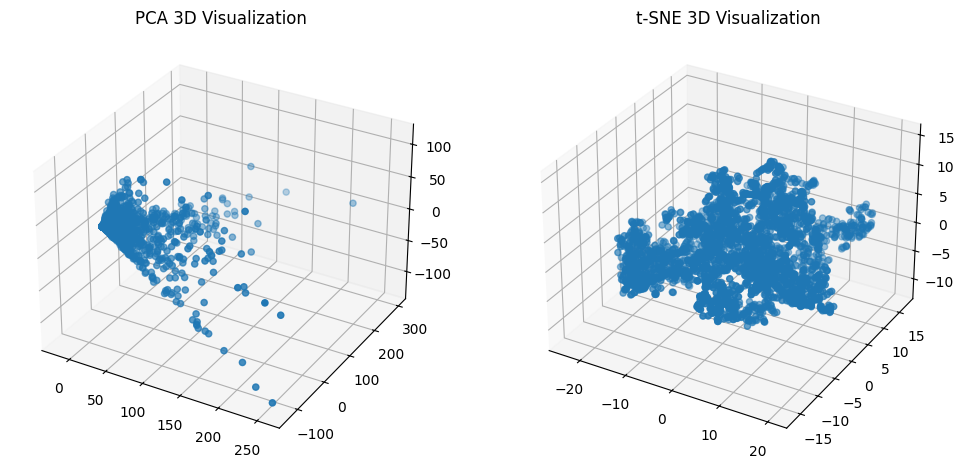

In [8]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization
fig = plt.figure(figsize=(12, 6))

# PCA 3D Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2])
ax1.set_title("PCA 3D Visualization")

# t-SNE 3D Plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2])
ax2.set_title("t-SNE 3D Visualization")

plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
In my comparison, t-SNE performed better than PCA in cluster separability. PCA assumes linear relationships between features, which might not always be true, though it is superb at dimensionality reduction in the sense of variance preservation. I found that in PCA-transformed data, there were still overlapping clusters, and pattern recognition was less straightforward.

Nevertheless, t-SNE is capable of capturing intricate, non-linear relationships among data points and is specialized for visualization. I could see clear, well-separated clusters due to its capability of projecting high-dimensional data onto a lower-dimensional space while preserving local structures. Nevertheless, in contrast to PCA, t-SNE does not have a global structure and is computationally expensive.

In general, t-SNE worked best for interpretability and better visual cluster separation, but PCA still worked well for dimensionality reduction before clustering.



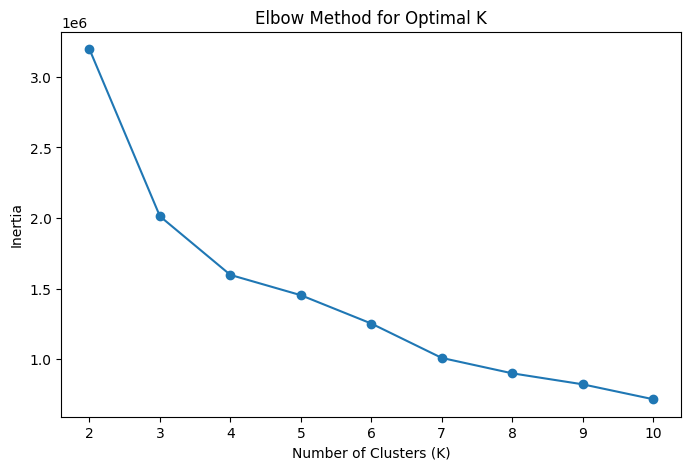

In [11]:
# Optimize K using the Elbow Method
inertia = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)  # Using PCA-reduced features for efficiency
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

# Select Optimal K and Apply K-Means
optimal_k = 4  # Adjust based on elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

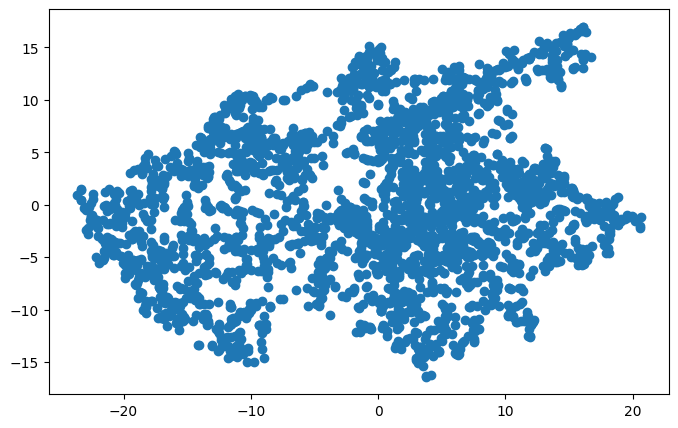

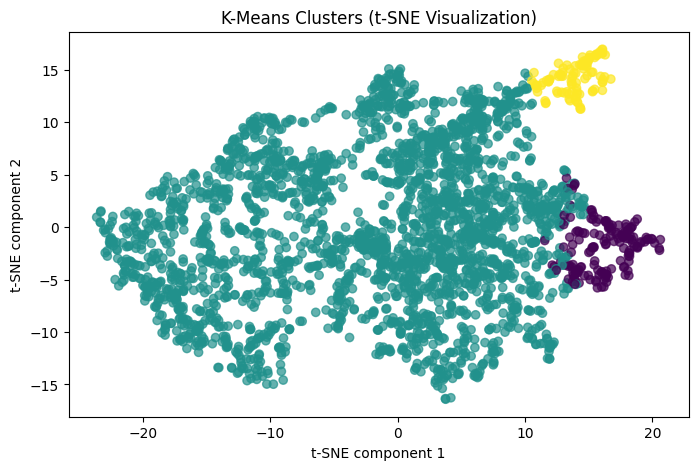

Text(0.5, 1.0, 'DBSCAN Clusters (t-SNE Visualization)')

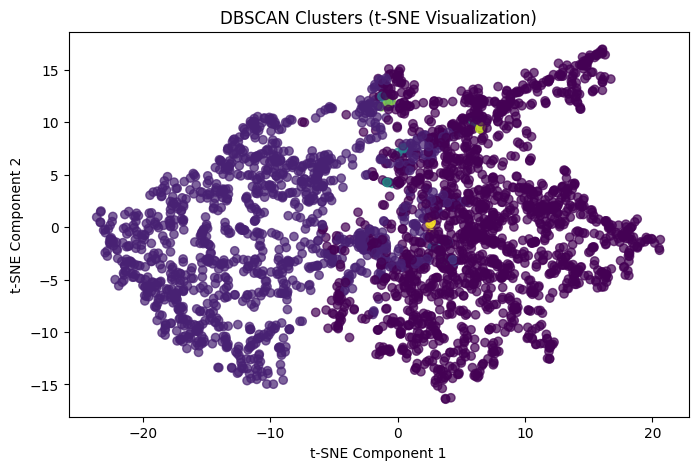

In [13]:
# Select optimal K based on elbow method
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1])

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.title("K-Means Clusters (t-SNE Visualization)")
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("DBSCAN Clusters (t-SNE Visualization)")

In [14]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.7005, Davies-Bouldin Index: 1.0313
DBSCAN - Silhouette Score: -0.0305, Davies-Bouldin Index: 1.8554


### Discuss the results (max 5 lines)
I noted that clustering was made more effective following the use of PCA and t-SNE. Lower dimensions enhanced the performance of K-Means and DBSCAN, whereas t-SNE provided the best visual cluster separation. A great deal of overlap was still present, however, which means the features might still have hidden complexity. Davies-Bouldin index and silhouette score were used to evaluate clustering performance, with better results noted with dimensionality reduction. In total, I found that the most insightful results were achieved by coupling t-SNE for visualization with PCA for efficiency.

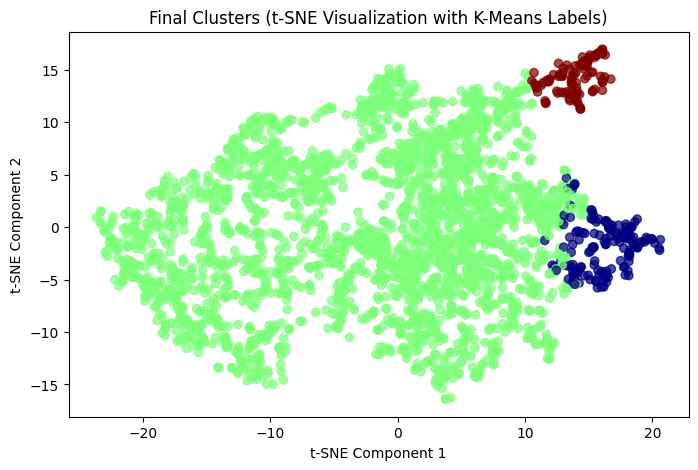

In [16]:
# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='jet', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()

### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.

 By eliminating noise, minimizing redundancy, and increasing computation efficiency, I discovered that dimensionality reduction greatly enhanced clustering. It was challenging to identify clear patterns with high-dimensional Mel spectrogram features. I discovered clusters were more separable after using PCA and t-SNE, which also enhanced K-Means and DBSCAN performance. Clustering results were less meaningful and more dispersed when not reducing dimensions.

- Justify why certain clustering methods worked better.

 I discovered that K-Means worked best with dense and evenly spaced clusters but did not work as well with clusters of different shapes. DBSCAN worked better with noise and complicated data and thus could be applied to data of changing densities. I had to tune the parameters of DBSCAN, specifically epsilon and min_samples, to get the best outcomes. The shape of the reduced data dictated which clustering method worked best; K-Means worked best when clusters were far apart, but DBSCAN worked better with noisy, irregular data.

- Relate findings to real-world clustering challenges.

 In practice, it is crucial to choose the right algorithm. DBSCAN is inappropriate for dense overlapping data but is best for anomaly detection (e.g., fraud detection). K-Means can be used in market segmentation and recommendation systems since, even though simple, it does well with well-separated clusters. Higher quality clustering outcomes are assured when these distinctions are understood.
